In [1]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy
import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=False)
from pathlib import Path
from tqdm import tqdm

from core.utils import *

In [2]:
pkl_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new'
pkl_path = Path(pkl_path)

In [3]:
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'SFs_pkls'

In [4]:
reweighting_vars = ['jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]

In [5]:
SFs = joblib.load(nominal_path / nominal_keys[0] / "SFs.pkl") # this includes many vars with WPs 

In [6]:
syst_config ={
    "trk_eff": {
        "has_subtype": True,
        "syst_subtype": trk_eff_uncertainties,
        "handle": 'quadratic',
    },
    "JESJER": {
        "has_subtype": True,
        "syst_subtype": JESJER_uncertainties,
        "handle": 'envelope',
    },
    "MC_nonclosure":{
        "has_subtype": False,
    },
    "gluon_reweight":{
        "has_subtype": False,
    },
    "pdf_weight":{
        "has_subtype": True,
        "syst_subtype": pdf_weight_uncertainties,
        "handle": 'envelope',
    }
}

special_processing = ['parton_shower', 'hadronization']

In [7]:
WPs = [0.5, 0.6, 0.7, 0.8]
for i_var, reweighting_var in enumerate(reweighting_vars[:1]):
    nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'SFs_pkls'
    nominal_SFs = joblib.load(nominal_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 

    syst_total = dict.fromkeys(syst_config.keys()) # syst_total['trk_eff', 'JESJER',...]
    for syst_type, value in tqdm(syst_config.items()):
        if syst_type in special_processing:
            continue 
        # Doing one syst 
        syst_total[syst_type] = syst_total.fromkeys(WPs) # syst_total['trk_eff'][0.5,0.6,0.7,0.8]

        if value['has_subtype']: # affect how the subtype is read 
            syst_sub_var = dict.fromkeys(value['syst_subtype']) # syst_sub_var['fake', 'eff']
            
            for syst_subtype in value['syst_subtype']: # loop on ['fake', 'eff'] 
                syst_sub_var[syst_subtype] = dict.fromkeys(WPs) # syst_sub_var['eff'][0.5,0.6,0.7,0.8]
                syst_path = pkl_path / syst_type / syst_subtype / 'plots' / 'ADE' / 'SFs_pkls'
                syst_SFs = joblib.load(syst_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 

                for WP in WPs:
                    syst_sub_var[syst_subtype][WP] = {
                        "Quark":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Quark"] \
                                                       - syst_SFs[reweighting_var][WP]["Quark"]),
                        "Gluon":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Gluon"] \
                                                       - syst_SFs[reweighting_var][WP]["Gluon"]),                                                       
                    } 
        
            # handle the subtypes inside one syst variant to report 1 
            if value['handle'] == 'quadratic':
                for WP in WPs:
                    syst_total[syst_type][WP] = {
                        "Quark" : np.zeros(len(label_pt_bin) - 1),
                        "Gluon" : np.zeros(len(label_pt_bin) - 1),
                    }
                for syst_subtype in value['syst_subtype']:
                    for WP in WPs:
                        for parton in ['Quark', 'Gluon']:
                            syst_total[syst_type][WP][parton] += np.power(syst_sub_var[syst_subtype][WP][parton], 2)

                for WP in WPs:
                    for parton in ['Quark', 'Gluon']:
                        syst_total[syst_type][WP][parton] = np.sqrt(syst_total[syst_type][WP][parton])
            
            if value['handle'] == 'envelope':
                for WP in WPs:
                    syst_total[syst_type][WP] = dict.fromkeys(['Quark', 'Gluon'])

                    for parton in ['Quark', 'Gluon']:
                        syst_subtype_var = []
                        for syst_subtype in value['syst_subtype']:
                            syst_subtype_var.append(syst_sub_var[syst_subtype][WP][parton])
                        syst_subtype_var = np.array(syst_subtype_var) # should be (num of subtypes, 6)
                        syst_total[syst_type][WP][parton] = np.max(np.abs(syst_subtype_var), axis=0) # the max along columns

        if not value['has_subtype']:  # for the case of MC_nonclosure, gluon_reweighting and MC:Powheg+Pythia 
            syst_path = pkl_path / syst_type / 'plots' / 'ADE' / 'SFs_pkls'
            syst_SFs = joblib.load(syst_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 
            for WP in WPs:
                syst_total[syst_type][WP] = {
                    "Quark":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Quark"] \
                                                    - syst_SFs[reweighting_var][WP]["Quark"]),
                    "Gluon":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Gluon"] \
                                                    - syst_SFs[reweighting_var][WP]["Gluon"]),                                                       
                } 



    # for WP in WPs:
    #     fig, ax = plt.subplots()
        
# 6 mins for trk_eff and JESJER
        

100%|██████████| 5/5 [04:37<00:00, 55.50s/it]


In [8]:
joblib.dump(syst_total, "dev_syst_total")

['dev_syst_total']

In [9]:
nominal_SFs['jet_nTracks'][0.5]['Quark']

array([1.0279333381553586+/-0.0018586113195646565,
       1.0443329347783434+/-0.0015922765556675275,
       1.0461937516008866+/-0.0028960158934784102,
       1.033476695908774+/-0.005694787038356356,
       1.0204495764454495+/-0.010449997703414317,
       1.00974996065689+/-0.02274082580019074], dtype=object)

In [10]:
syst_total['pdf_weight']

{0.5: {'Quark': array([0.09400601, 0.10558127, 0.12462188, 0.13080061, 0.12813094,
         0.10506419]),
  'Gluon': array([0.04116864, 0.04866427, 0.05336136, 0.06130613, 0.06124703,
         0.05209064])},
 0.6: {'Quark': array([0.08714222, 0.09802826, 0.11597292, 0.12177193, 0.11701459,
         0.09970553]),
  'Gluon': array([0.04968296, 0.05677311, 0.06133915, 0.07045771, 0.06916023,
         0.06216799])},
 0.7: {'Quark': array([0.07855618, 0.08894293, 0.10555979, 0.11170789, 0.10522894,
         0.08101119]),
  'Gluon': array([0.05684771, 0.06328601, 0.06760012, 0.07863205, 0.08180622,
         0.06689996])},
 0.8: {'Quark': array([0.06367126, 0.07249677, 0.08714585, 0.08731948, 0.08183825,
         0.06410169]),
  'Gluon': array([0.06480247, 0.06971449, 0.07391993, 0.0892084 , 0.09046066,
         0.07560348])}}

In [12]:
syst_total['MC_nonclosure']

{0.5: {'Quark': array([0.01585456, 0.03721251, 0.04293122, 0.03241652, 0.01971057,
         0.01004873]),
  'Gluon': array([-0.00877816, -0.01293758, -0.01908834, -0.03606487, -0.05665901,
         -0.0749222 ])},
 0.6: {'Quark': array([0.02476983, 0.03934177, 0.04440905, 0.03357727, 0.01767541,
         0.01878878]),
  'Gluon': array([-0.01010722, -0.01723766, -0.02404901, -0.04241774, -0.07364608,
         -0.08015492])},
 0.7: {'Quark': array([0.03140308, 0.03994382, 0.04373557, 0.03510246, 0.02377965,
         0.00707627]),
  'Gluon': array([-0.00894136, -0.02006304, -0.02866807, -0.04611008, -0.07988401,
         -0.12412074])},
 0.8: {'Quark': array([0.03226853, 0.03627098, 0.03805931, 0.03062514, 0.01832343,
         0.00825793]),
  'Gluon': array([-0.0080001 , -0.02561356, -0.03780239, -0.05786523, -0.10348701,
         -0.14692883])}}

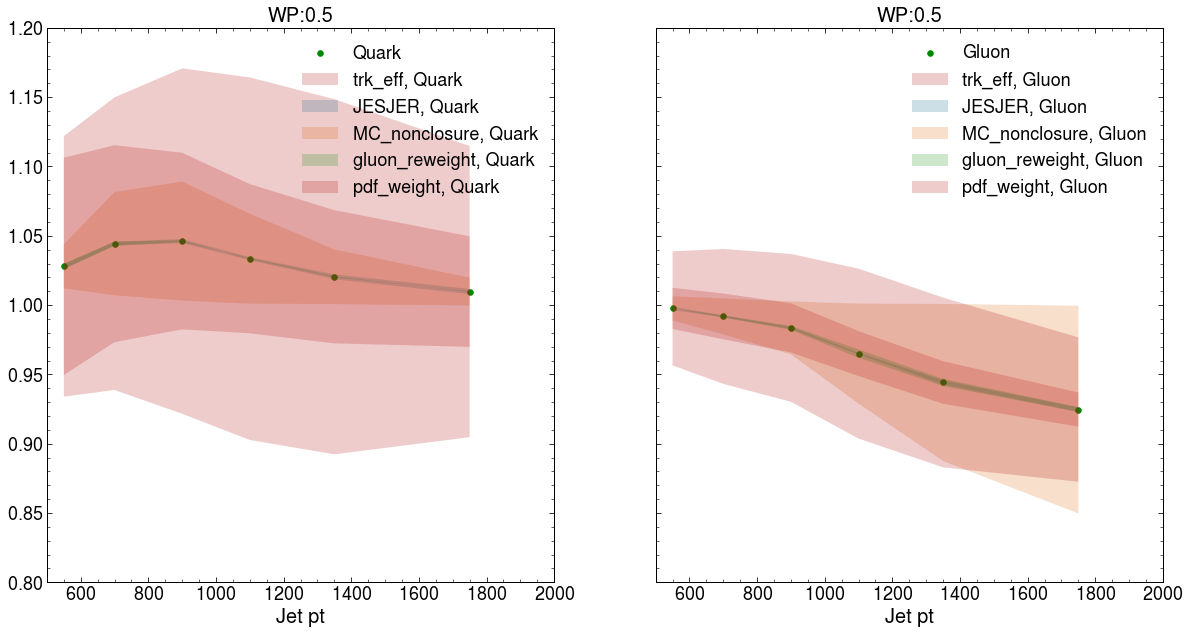

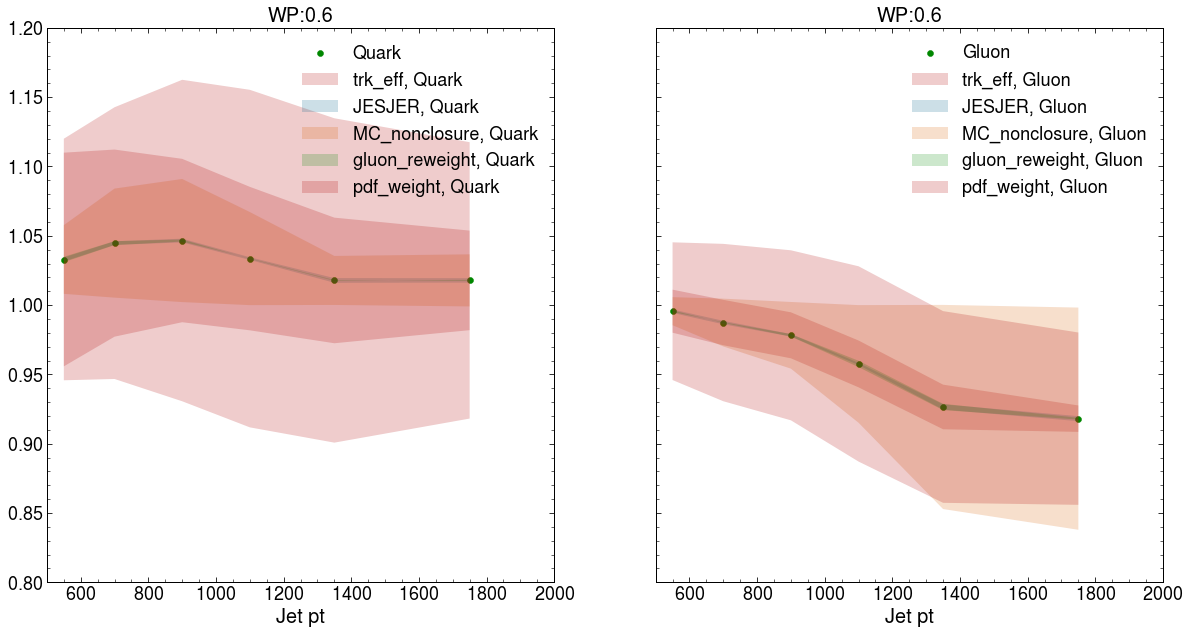

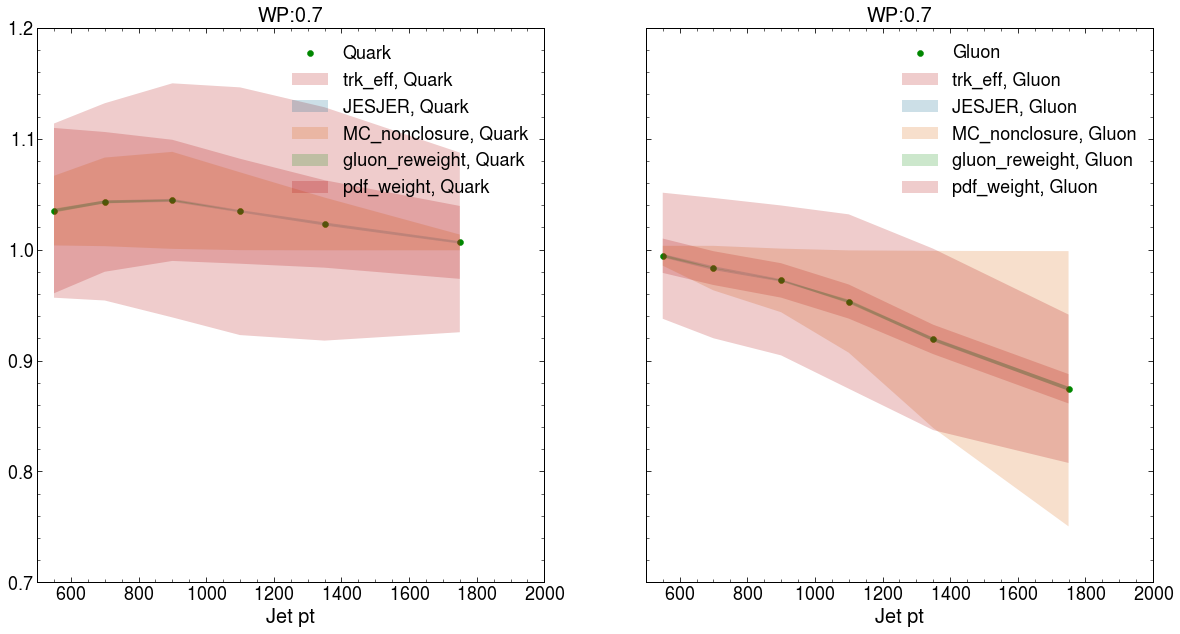

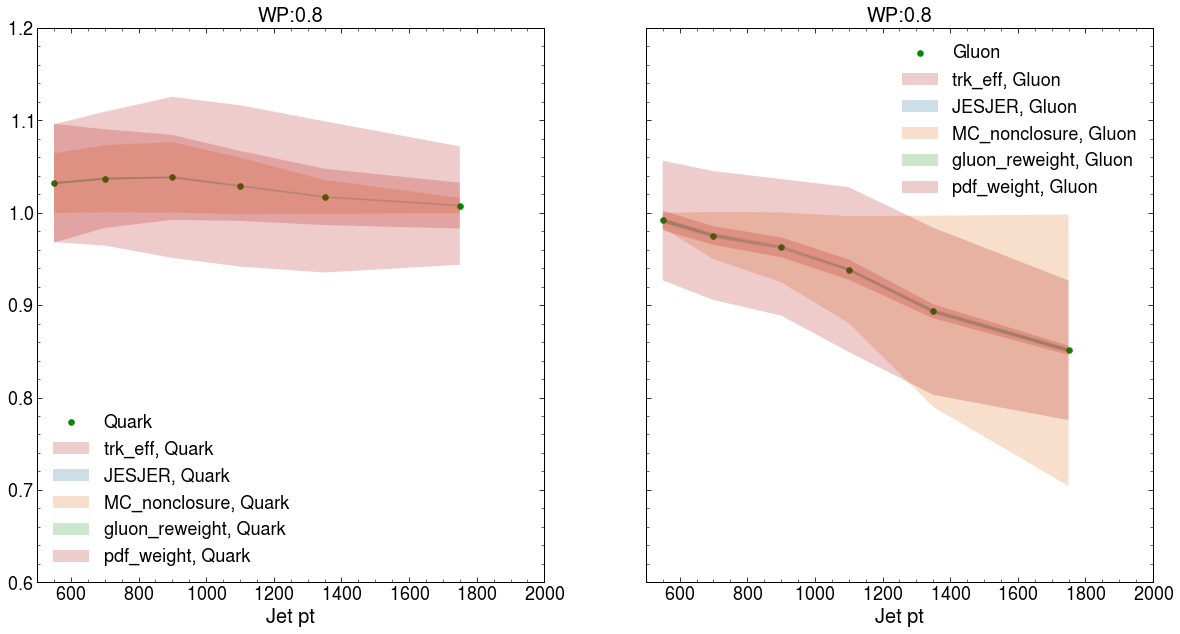

In [11]:
bin_centers = 0.5 * (np.array(label_pt_bin[:-1]) + np.array(label_pt_bin[1:]))

for WP in WPs:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
    quark_nominal_values = unumpy.nominal_values(nominal_SFs['jet_nTracks'][WP]['Quark'])
    gluon_nominal_values = unumpy.nominal_values(nominal_SFs['jet_nTracks'][WP]['Gluon'])
    ax[0].scatter(bin_centers, quark_nominal_values, label = "Quark")
    ax[1].scatter(bin_centers, gluon_nominal_values, label = "Gluon")

    for key in syst_total.keys():
        quark_uncertainty = syst_total[key][WP]['Quark']
        ax[0].fill_between(bin_centers, quark_nominal_values-quark_uncertainty, quark_nominal_values+quark_uncertainty, \
                        # color='b',
                        alpha=0.2, label=f'{key}, Quark')

        gluon_uncertainty = syst_total[key][WP]['Gluon']
        ax[1].fill_between(bin_centers, gluon_nominal_values-gluon_uncertainty, gluon_nominal_values+gluon_uncertainty, \
                        # color='r', 
                        alpha=0.2, label=f'{key}, Gluon')
    # ax.scatter(bin_centers, unumpy.nominal_values(nominal_SFs['jet_nTracks'][WP]['Gluon']), label = "Gluon")
    for i in range(len(ax)):
        ax[i].set_xlim(label_pt_bin[0], label_pt_bin[-1])
        ax[i].set_title(f"WP:{WP}")
        ax[i].set_xlabel("Jet pt")
        ax[i].legend()

